In [1]:
import numpy as np
import pandas as pd
import collections
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
import math
import matplotlib.pyplot as plt
from scipy.special import zeta
from wordcloud import WordCloud
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

#### Helpful functions

In [2]:
def seed_words(path:str):
    list_seed_words = []
    with open(file=path, mode="r", encoding="utf8") as f:
        for line in f:
            list_seed_words.append(re.sub("\n", "", line))

    return list_seed_words

def extract_year(date: str):
    return date[:4]

def list_to_dict_count(lst:list):
    out = nltk.defaultdict(int)
    for token in lst:
        out[token] += 1
    return sorted(out.items(), key=lambda x : x[1], reverse=True)

def top_n_not_stopwords(d: dict, n=10):
    out = nltk.defaultdict(list)
    stopwords_english = set(stopwords.words("english"))
    sorted_data = dict(sorted(d.items()))
    for k, v in sorted_data.items():
        for value in v:
            if value[0] not in stopwords_english:
                out[k].append(value)
    return out

In [3]:
#load datasets
df_igbt = pd.read_csv("assign1_data/lgbt_news_corpus.csv", encoding="ISO-8859-1")
df_bg = pd.read_csv("assign1_data/background_news_corpus.csv", encoding="ISO-8859-1")

C:\Users\azizc\AppData\Local\Temp\ipykernel_32656\4241532332.py:2: DtypeWarning: Columns (7,8,10,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_igbt = pd.read_csv("assign1_data/lgbt_news_corpus.csv", encoding="ISO-8859-1")


In [4]:
df_igbt.columns

Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')

In [5]:
df_bg.columns

Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category'], dtype='object')

In [6]:
#remove unnamed columns to be able to merge both datasets together later on
df_igbt = df_igbt[["Text", "Title", "Id", "Count", "Date", "Category"]]

In [7]:
df_igbt.columns

Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category'], dtype='object')

In [8]:
# merge both datasets
frames = [df_igbt, df_bg]
merged_dataset = pd.concat(frames)

In [9]:
merged_dataset.columns

Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category'], dtype='object')

In [10]:
len(merged_dataset) == len(df_igbt) + len(df_bg)

True

In [11]:
len(merged_dataset)

69240

In [12]:
# preprocess the dataset
# Add YEAR column from DATE 
merged_dataset["Year"] = merged_dataset["Date"].apply(lambda d: extract_year(d))

#lowercase the text
merged_dataset["Text_Lower"] = merged_dataset["Text"].apply(lambda t: str(t).lower())

In [13]:
seed_words_list = seed_words("assign1_data\seed_list.txt")

In [14]:
def context(dataF, seed_list: list, window_size=3):
    text_data = dataF["Text_Lower"].values
    years = dataF["Year"].values
    word_per_years = nltk.defaultdict(list)
    occurence = nltk.defaultdict(int)
    seed_year_words_count_dict = nltk.defaultdict(dict)

    for seed_w in seed_list:
        for g_idx, sent in enumerate(text_data):
            #preprocessing
            sent_prep_0 = re.sub("\'\'", "", sent)
            sent_prep_1 = re.sub("``", "", sent_prep_0)
            sent_prep_2 = re.sub("\'s", "", sent_prep_1) 
            sent_prep_2 = re.sub(r"''", "", sent_prep_2)
            sent_prep_2 = re.sub(r"\'", "", sent_prep_2)
            sent_prep_3 = re.sub(r'[^\x00-\x7F]+', '', sent_prep_2) #remove all non-ASCII characters
            year = int(years[g_idx])

            tokens = word_tokenize(sent_prep_3)
            tokens_words = [w for w in tokens if w not in string.punctuation]
            
            for idx, t in enumerate(tokens_words):
                #surroundings = []
                if t == seed_w:
                    left_words = tokens_words[max(0, idx-3):idx]
                    right_words = tokens_words[idx+1:min(idx+4, len(tokens_words))]
                    context_words = left_words + right_words
                    for c_w in context_words:
                        #occurence[c_w] += 1
                        word_per_years[year].append(c_w)
                    
        seed_year_words_count_dict[seed_w] = word_per_years
    #return occurence, sorted(occurence.items(), key= lambda x : x[1], reverse=True), word_per_years
    return seed_year_words_count_dict


In [15]:
contex_dict = context(dataF=merged_dataset, seed_list=seed_words_list)

In [16]:
list_to_dict_count(contex_dict["gay"][2014])[:10]

[('and', 545),
 ('marriage', 376),
 ('the', 364),
 ('to', 289),
 ('of', 282),
 ('a', 213),
 ('gay', 191),
 ('in', 189),
 ('couples', 157),
 ('on', 154)]

In [17]:
def sort_context_dict(context_dict: dict, remove_stop=False) -> dict:
    out = {}
    tmp = {}
    for k,v in context_dict.items():
        for y, l in sorted(v.items()):
            tmp[y] = dict(list_to_dict_count(l))
            if remove_stop:
                no_stops = [item for item in l if item[0] not in set(stopwords.words("english"))]
                tmp[y] =  dict(list_to_dict_count(no_stops))
        out[k] = tmp
    return out

In [22]:
sorted_context_dict = sort_context_dict(context_dict=contex_dict)

In [30]:
def plot_word_clouds(top_words:dict, df_name:str, seed_word:str, year:int) -> None:
    #top_words_sorted_year = sorted(top_words.items(), key=lambda x: x[0])
    #lst_years = list(dict(top_words_sorted_year).keys())

    
    #dict_of_year = dict(dict(top_words_sorted_year)[y])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words[seed_word][year])
    # Plot the word cloud
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Context of [{seed_word}] in year {year}")
    plt.axis('off')
    plt.tight_layout(pad=0)
    full_name = df_name + "_" + seed_word + "_" + str(year) 
    fig.savefig("seed_word_plots/" + full_name + ".png")
    plt.show()

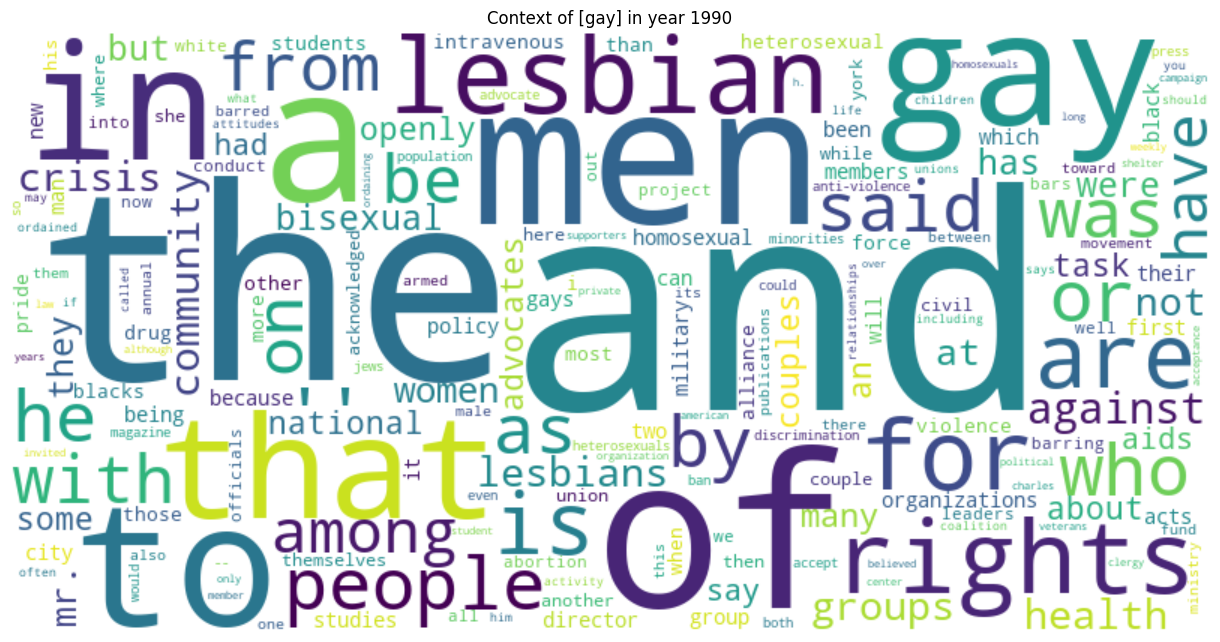

In [35]:
plot_word_clouds(sorted_context_dict, "merged", "gay", 1990)

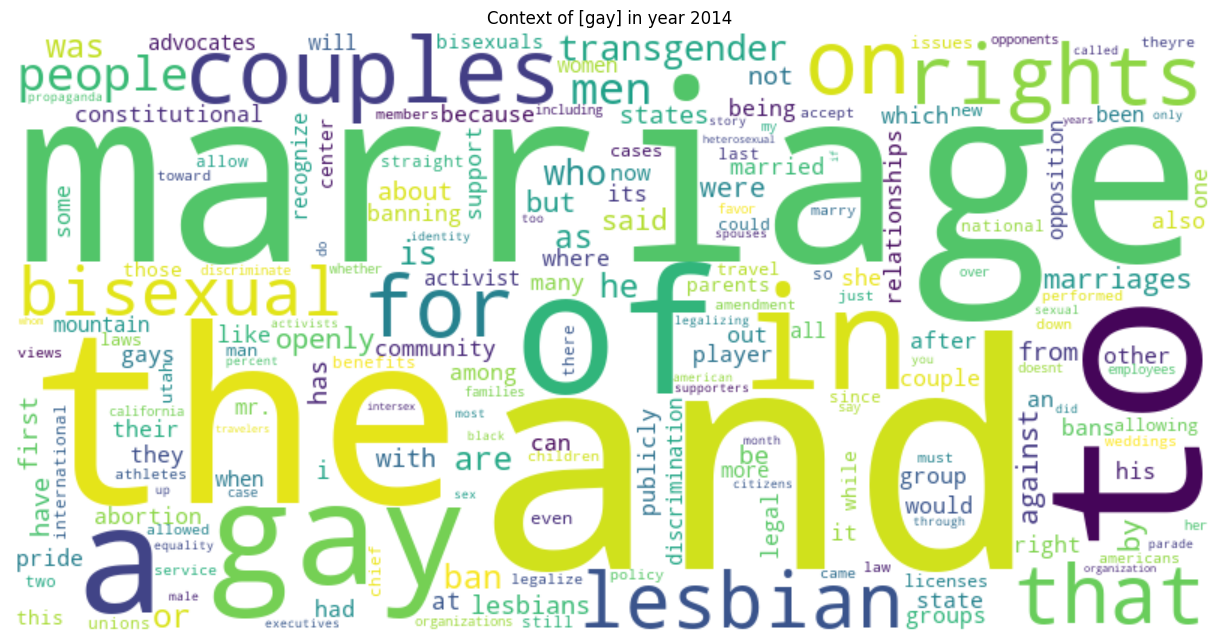

In [36]:
plot_word_clouds(sorted_context_dict, "merged", "gay", 2014)

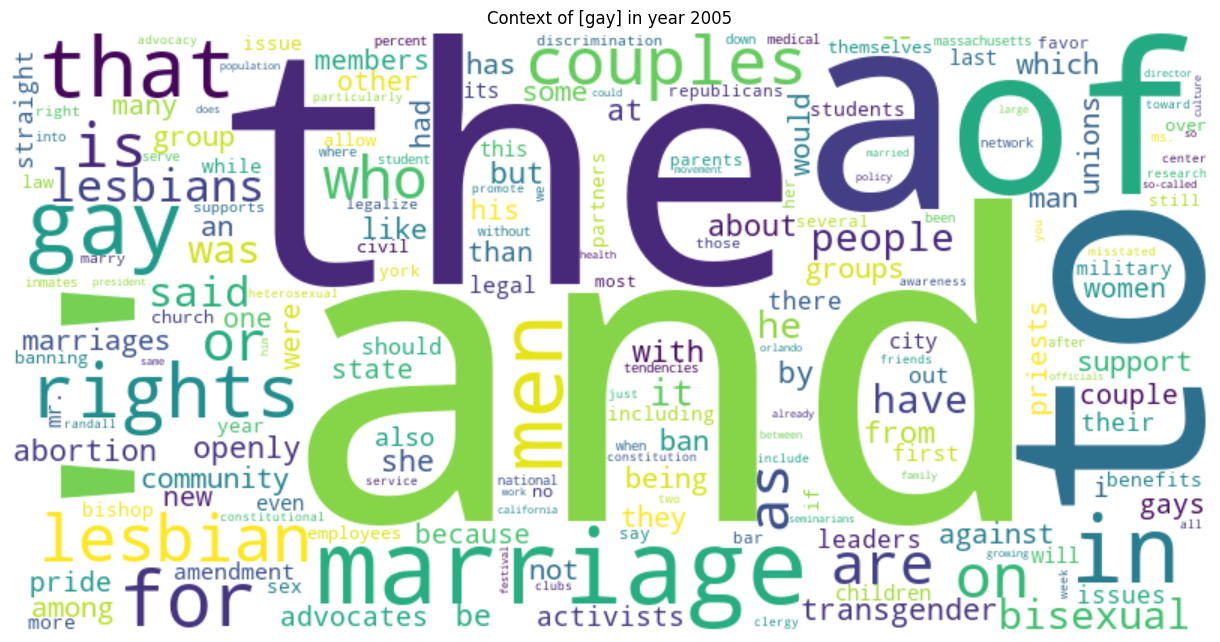

In [32]:
plot_word_clouds(sorted_context_dict, "merged", "gay", 2005)

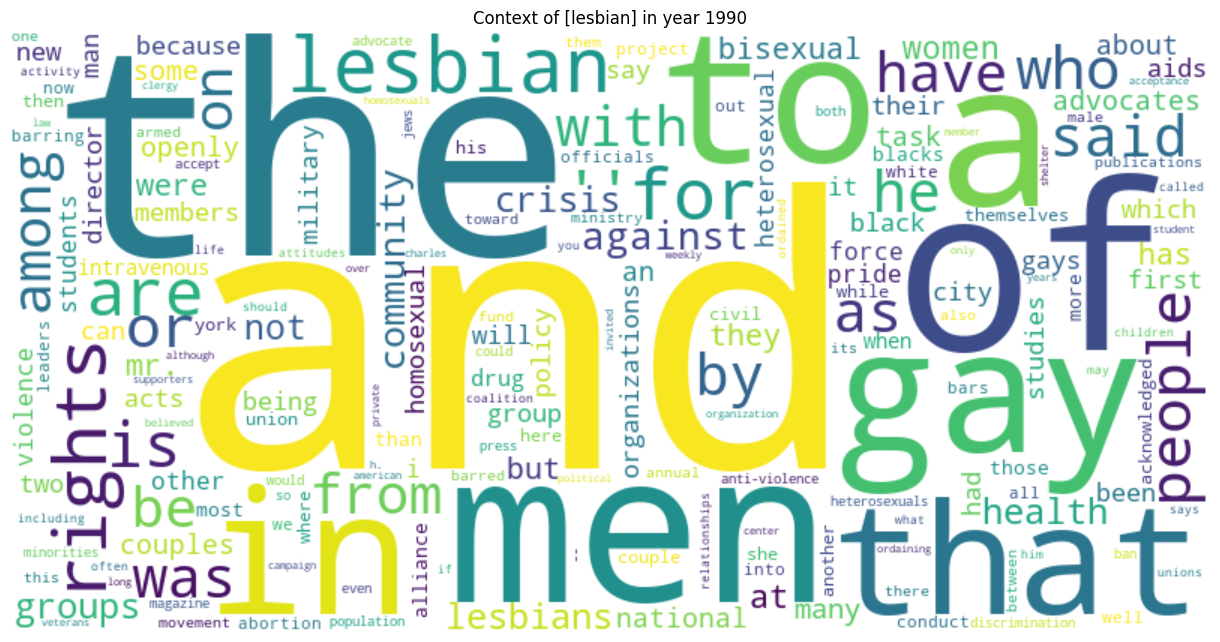

In [37]:
plot_word_clouds(sorted_context_dict, "merged", "lesbian", 1990)

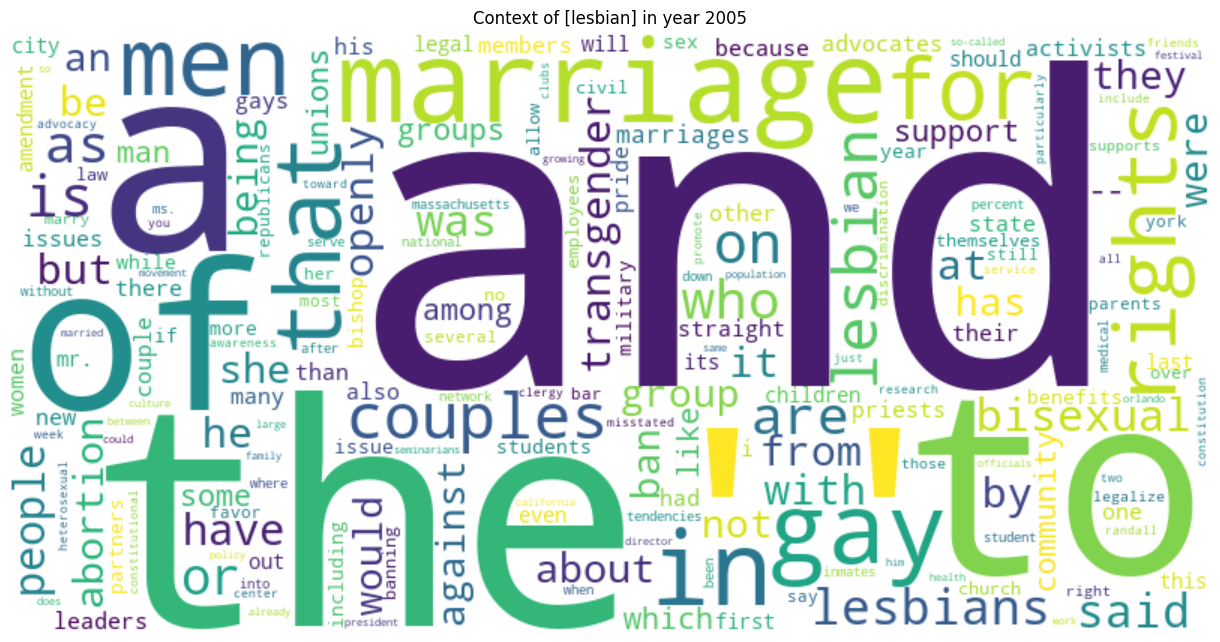

In [38]:
plot_word_clouds(sorted_context_dict, "merged", "lesbian", 2005)

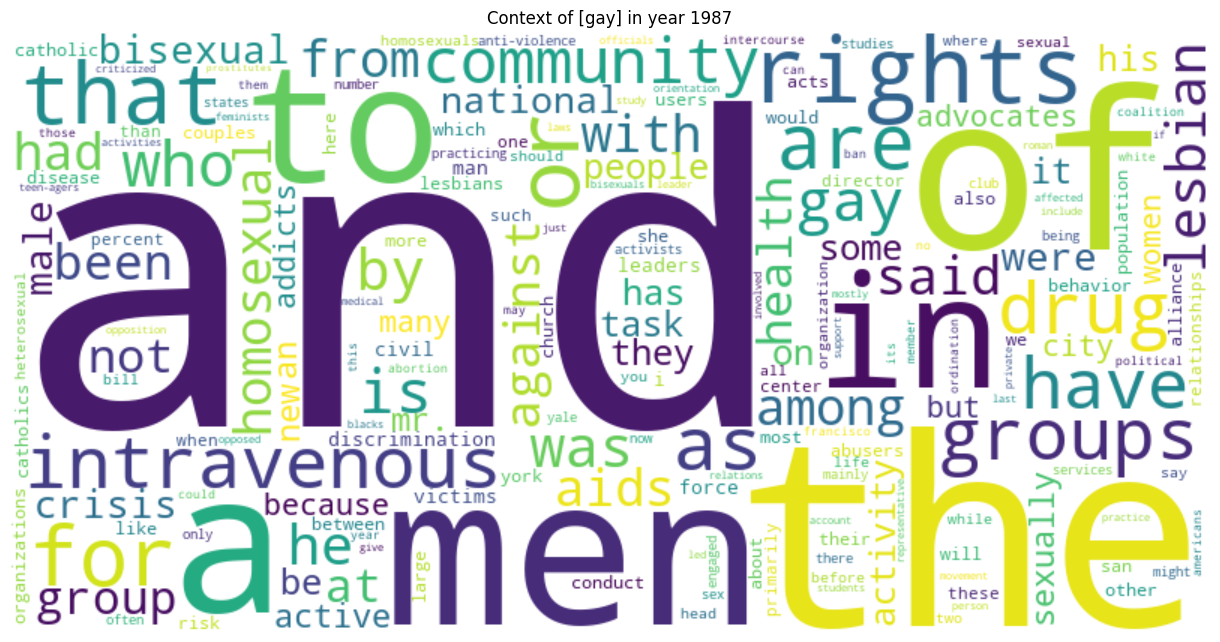

In [40]:
plot_word_clouds(sorted_context_dict, "merged", "gay", 1987)